In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras import datasets, layers, models
from keras.layers import GlobalAveragePooling2D, TimeDistributed, Dense, LSTM, GRU, Conv2D, MaxPooling2D, Flatten 
from keras.layers import Input, Rescaling, BatchNormalization, Activation, SeparableConv2D, Reshape, SimpleRNN 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
from pathlib import Path
from imutils import paths
import cv2
from matplotlib import pyplot as plt

In [2]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

In [3]:
input_shape =  (224, 224, 3)
batch_size = 64
time_dist = 8
trsplit = (0.0, 0.7)
valsplit = (0.7, 0.85)
tesplit = (0.85, 1.0)

org_path = Path(r"C:\Users\SWQA\Desktop\STAJ\Metamorphose\Videos\1")
class_paths = [Path(r"class08_30_20"), Path(r"classsenay_1"), Path(r"class16_46_57")]

In [4]:
all_labels = [i for i in os.walk(org_path / class_paths[0] / "Train" / "Label")][0][2]

lie_len = len([i for i in all_labels if i.endswith("l.jpeg")])
err_len = len([i for i in all_labels if i.endswith("e.jpeg")])
both_len = len(all_labels) - lie_len - err_len
none_len = len(list(os.walk(org_path / class_paths[0] / "Train"))[0][2]) - len(all_labels)
all_len = lie_len + err_len + both_len + none_len
print(both_len)
print(lie_len)
print(err_len)
print(none_len)
print(all_len)

class_count = 4

0
7750
216
1769
9735


In [5]:
lie_weight = all_len / ((class_count * lie_len) + 0.000001)
err_weight = all_len / ((class_count * err_len) + 0.000001)
both_weight = all_len / ((class_count * both_len) + 0.000001)
none_weight = all_len / ((class_count * none_len) + 0.000001)
print(both_weight)
print(lie_weight)
print(err_weight)
print(none_weight)

weight_dict = [
    lie_weight,
    err_weight,
    both_weight,
    none_weight
]
weight_dict2 = {
    both_weight: [1, 0],
    lie_weight:  [0, 1],
    err_weight:  [1, 1],
    none_weight: [0, 0]
}

9735000000.0
0.31403225805438606
11.267361098070184
1.3757772751023492


In [6]:
def ins_ind(string, char, index):
        return string[:index] + char + string[index:] 

def __data_gen(wtype, iclass, split):    
    imgs = []    
    lbls = []
    weights = []
    img_dist = []
    lbls = []
    weight_dist = []
    
    bcounter = 0
    
    seed = 0
    for c in wtype:
        seed += ord(c)
    
    np.random.seed(seed)
    shuffled = np.asarray(sorted(list(os.walk(org_path / class_paths[0] / "Train"))[0][2], key=lambda x: len(x)))
    shuffled = shuffled[int(len(shuffled) * split[0]):int(len(shuffled) * split[1])]
    # np.random.shuffle(shuffled)

    #unroll
    for p in shuffled[:time_dist]:        
        img = cv2.imread(str(org_path / iclass / wtype / p), cv2.IMREAD_COLOR)
        img = cv2.resize(img, input_shape[:-1])
        
        img_dist.append(img)

        if os.path.isfile(org_path / iclass / wtype / "Label" / shuffled[time_dist]):
            weight_dist.append(both_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'l', shuffled[time_dist].index('.'))):
            weight_dist.append(lie_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'e', shuffled[time_dist].index('.'))):
            weight_dist.append(err_weight)
        else:
            weight_dist.append(none_weight)

    if os.path.isfile(org_path / iclass / wtype / "Label" / shuffled[time_dist]):
        lbls.append([1, 1])
    elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'l', shuffled[time_dist].index('.'))):
        lbls.append([1, 0])
    elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'e', shuffled[time_dist].index('.'))):
        lbls.append([0, 1])
    else:
        lbls.append([0, 0])


    imgs.append(np.asarray(img_dist, dtype=np.uint8))
    weights.append(np.asarray(weight_dist, dtype=np.float32))

    bcounter += 1

    for p in range(time_dist, len(shuffled) - 1):
        img_index = shuffled[p]
        lbl_index = shuffled[p + 1]

        img = cv2.imread(str(org_path / iclass / wtype / img_index), cv2.IMREAD_COLOR)
        img = cv2.resize(img, input_shape[:-1])

        img_dist.append(img)
        del img_dist[0]

        if os.path.isfile(org_path / iclass / wtype / "Label" / shuffled[time_dist]):
            lbls.append([1, 1])
            weight_dist.append(both_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'l', shuffled[time_dist].index('.'))):
            lbls.append([1, 0])
            weight_dist.append(lie_weight)
        elif os.path.isfile(org_path / iclass / wtype / "Label" / ins_ind(shuffled[time_dist], 'e', shuffled[time_dist].index('.'))):
            lbls.append([0, 1])
            weight_dist.append(err_weight)
        else:
            lbls.append([0, 0])
            weight_dist.append(none_weight)
        del weight_dist[0]

        imgs.append(np.asarray(img_dist, dtype=np.uint8))
        weights.append(np.asarray(weight_dist, dtype=np.float32))

        bcounter += 1

        if bcounter % batch_size == 0:
            bcounter = 0
            yield (np.asarray(imgs, dtype=np.uint8), np.asarray(lbls, dtype=np.float32))
            imgs = []
            lbls = []
            weights = []

def load_data():
    signature = (
        tf.TensorSpec(shape=(batch_size, time_dist, *input_shape), dtype=tf.uint8),
        tf.TensorSpec(shape=(batch_size, *(2,)), dtype=tf.float32),
        # tf.TensorSpec(shape=(batch_size, time_dist), dtype=tf.float32)
    )
    
    for iclass in class_paths:
        trdir_path = org_path / iclass / "Train"
        valdir_path = org_path / iclass / "Val"
        tedir_path = org_path / iclass / "Test"
        
        train_dataset = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", iclass, trsplit),
            output_signature=signature
        )

        val_dataset = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", iclass, valsplit),
            output_signature=signature
        )

        test_dataset = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", iclass, tesplit),
            output_signature=signature
        )
        
        return train_dataset, val_dataset, test_dataset

In [7]:
tr, val, te = load_data()

In [8]:
tr = tr.shuffle(256)
val = val.shuffle(256)
te = te.shuffle(256)

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(64, 2), dtype=float32)


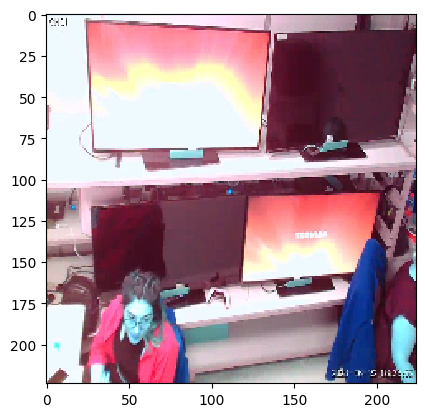

In [40]:
iiasdasd = 0
for t in tr:
    if iiasdasd >= 6:
        print(t[1])
        plt.imshow(t[0][0][0], interpolation='nearest')
        plt.show()
        break
    iiasdasd += 1

In [174]:
sota_cnn = MobileNetV2(include_top=False)

In [175]:
inputs = keras.Input(shape=(time_dist, *input_shape), batch_size=batch_size, dtype=tf.uint8)

In [203]:
def metamorph_loss(weights):
    def inner_loss(y_true, y_pred):
        warr = tf.not_equal(y_true, 1)
        warr = warr

        cw = []
        for w in warr:
            temp = np.empty((2,), dtype=np.float32)
            if tf.reduce_all(tf.math.logical_xor(w, tf.constant([True, False]))):
                temp.fill(weights[0])
            elif tf.reduce_all(tf.math.logical_xor(w, tf.constant([False, True]))):
                temp.fill(weights[1])
            elif tf.reduce_all(tf.math.logical_xor(w, tf.constant([True, True]))):
                temp.fill(weights[2])
            elif tf.reduce_all(tf.math.logical_xor(w, tf.constant([False, False]))):
                temp.fill(weights[3])

            cw.append(temp)
        
        loss = tf.keras.backend.binary_crossentropy(y_true, y_pred, np.asarray(cw))
        # loss = tf.multiply(np.asarray(cw), loss)
        # tf.print(loss)

        return loss
    
    return inner_loss

In [180]:
xx = TimeDistributed(sota_cnn)(inputs)
xx = TimeDistributed(Flatten())(xx)
xx = LSTM(
    8,
    activation="relu",
    return_sequences=True,
    return_state=True,
    unroll=True,
    stateful=True)(xx)
xx = LSTM(
    8,
    activation="relu",
    return_sequences=True,
    return_state=True,
    unroll=True,
    stateful=True)(xx)
xx = LSTM(
    8,
    activation="relu",
    unroll=True,
    stateful=True)(xx)
out = Dense(2, activation='sigmoid')(xx)

metamorph = tf.keras.Model(inputs, out)

for layer in sota_cnn.layers:
    layer.trainable = False

metamorph.compile(    
    optimizer='Adam',
    loss=metamorph_loss(weight_dict),
    metrics=[        
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TruePositives(),
        "categorical_accuracy"
    ]
)

In [159]:
metamorph.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(64, 8, 224, 224,   0           []                               
                                3)]                                                               
                                                                                                  
 time_distributed_23 (TimeDistr  (64, 8, 7, 7, 1280)  2257984    ['input_19[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 time_distributed_24 (TimeDistr  (64, 8, 62720)      0           ['time_distributed_23[0][0]']    
 ibuted)                                                                                   

In [181]:
train_len_fe = list(os.walk(org_path / class_paths[0] / "Train"))[0][2]

history1 = metamorph.fit(
    tr.repeat(),
    epochs=100,
    steps_per_epoch=len(train_len_fe[int(len(train_len_fe) * trsplit[0]):int(len(train_len_fe) * trsplit[1])]) // batch_size,
    validation_steps=len(train_len_fe[int(len(train_len_fe) * valsplit[0]):int(len(train_len_fe) * valsplit[1])]) // batch_size,
    validation_data=val.repeat()
)

Epoch 1/100
[[0.982688606 0.930645168]
 [0.989477158 0.923793]
 [0.996385694 0.914541423]
 ...
 [1.01655209 0.889861226]
 [1.02469122 0.885015368]
 [1.03227913 0.88117224]]
  1/106 [..............................] - ETA: 6:27 - loss: 0.9612 - mean_squared_error: 0.2527 - root_mean_squared_error: 0.5027 - false_negatives_14: 64.0000 - true_negatives_14: 64.0000 - false_positives_14: 0.0000e+00 - true_positives_14: 0.0000e+00 - categorical_accuracy: 0.2500[[1.52146947 0.512364268]
 [1.52425706 0.510513961]
 [1.52846634 0.507702351]
 ...
 [1.52476645 0.509100914]
 [1.51777768 0.513063312]
 [1.51779807 0.513468504]]
  2/106 [..............................] - ETA: 1:11 - loss: 0.9867 - mean_squared_error: 0.2617 - root_mean_squared_error: 0.5115 - false_negatives_14: 128.0000 - true_negatives_14: 128.0000 - false_positives_14: 0.0000e+00 - true_positives_14: 0.0000e+00 - categorical_accuracy: 0.6250[[0.997273326 0.904722631]
 [0.997617543 0.90415132]
 [1.00926745 0.890138209]
 ...
 [0.99330

KeyboardInterrupt: 

In [258]:
tr_deneme = tr.take(285)

In [260]:
iiasdas = 0

for iasdd in tr_deneme:
    print(iiasdas, iasdd[1])
    iiasdas += 1

0 tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(64, 2), dtype=float32)
1 tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0

In [256]:
iitr = 0
for t in tr.as_numpy_iterator():
    if tf.reduce_all(t[1][0] == [0., 1.]):
        print(iitr)
    iitr += 1

In [31]:
tf.reduce_all(tf.constant([1., 0.]) == tf.constant([1., 0.]))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [17]:
def preddd2(x, y):
    print(x, y)
    return tf.reduce_all(y[0] == [., 0.])

In [21]:
preddd = lambda x, y: tf.reduce_all(y[0] == tf.constant([0., 1.]))

In [34]:
for ttteee in tr.as_numpy_iterator():
    print(ttteee[1][0])

[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]


In [22]:
dtstnew = te.filter(preddd2)

Tensor("args_0:0", shape=(64, 8, 224, 224, 3), dtype=uint8) Tensor("args_1:0", shape=(64, 2), dtype=float32)


In [23]:
len(list(dtstnew.as_numpy_iterator()))


22

In [187]:
metamorph.predict(
    te.take(1)
)

1/1 [==============================] - 1s 692ms/step


array([[1.00000000e+00, 1.05599548e-26],
       [1.00000000e+00, 9.56938814e-27],
       [1.00000000e+00, 8.27178514e-27],
       [1.00000000e+00, 3.50386823e-27],
       [1.00000000e+00, 5.01161446e-27],
       [1.00000000e+00, 3.60744859e-27],
       [1.00000000e+00, 8.74292846e-27],
       [1.00000000e+00, 9.36230522e-27],
       [1.00000000e+00, 2.47697024e-26],
       [1.00000000e+00, 9.23729157e-27],
       [1.00000000e+00, 5.34221689e-27],
       [1.00000000e+00, 2.13662398e-27],
       [1.00000000e+00, 4.90957137e-27],
       [1.00000000e+00, 4.78864300e-27],
       [1.00000000e+00, 2.16077014e-27],
       [1.00000000e+00, 3.36886362e-27],
       [1.00000000e+00, 5.96615426e-27],
       [1.00000000e+00, 4.10899041e-27],
       [1.00000000e+00, 6.08468523e-27],
       [1.00000000e+00, 5.39137279e-27],
       [1.00000000e+00, 1.09359595e-26],
       [1.00000000e+00, 1.39536475e-26],
       [1.00000000e+00, 1.79653919e-26],
       [1.00000000e+00, 1.57504554e-26],
       [1.000000

In [91]:
for layer in metamorph.layers[:25]:
   layer.trainable = False
for layer in metamorph.layers[25:]:
   layer.trainable = True
   
from tensorflow.keras.optimizers import SGD
metamorph.compile(
   optimizer=SGD(lr=0.0001, momentum=0.9),
   loss='binary_crossentropy',
   metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.F1Score(),
        "accuracy"
   ]
)

In [ ]:
history2 = metamorph.fit(
    tr.repeat(),
    epochs=25,
    batch_size=batch_size,
    steps_per_epoch=len(list(os.walk(org_path / class_paths[0] / "Train"))[0][2]) // batch_size,
    validation_steps=len(list(os.walk(org_path / class_paths[0] / "Val"))[0][2]) // batch_size,
    validation_data=val.repeat()
)

In [289]:
signature = (tf.TensorSpec(shape=(None, *input_shape), dtype=tf.uint8),
                 tf.TensorSpec(shape=(None, 1), dtype=tf.uint8))

train_dataset2 = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", class_paths[1]),
            output_signature=signature
        )

(224, 224, 3)


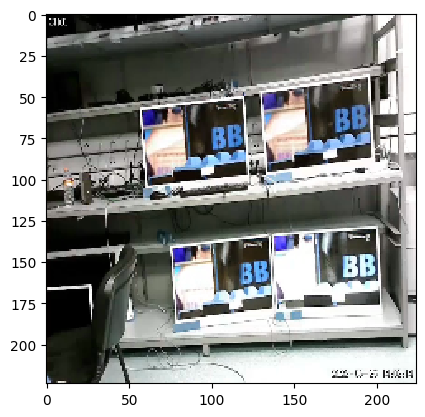

In [291]:
for tt in train_dataset2:
    print(tt[0][1].shape)
    plt.imshow(tt[0][1], interpolation='nearest')
    plt.show()
    break

In [288]:
metamorph.evaluate(
    te.repeat(),
    steps=len(list(os.walk(org_path / class_paths[0] / "Test"))[0][2]) // batch_size
)

193/193 [==============================] - 181s 916ms/step - loss: 7.3504e-04 - mean_squared_error: 1.6529e-04 - root_mean_squared_error: 0.0129 - false_negatives_7: 0.0000e+00 - true_negatives_7: 1142.0000 - false_positives_7: 1.0000 - true_positives_7: 5033.0000 - accuracy: 0.9998


[0.000735042616724968,
 0.00016529230924788862,
 0.012856605462729931,
 0.0,
 1142.0,
 1.0,
 5033.0,
 0.9998380541801453]

In [179]:
calc_f1(0.9561, 0.9509)

0.9534929103303618

In [ ]:
W1

false_negatives 0.0
true_negatives  1142.0
false_positives 1.0
true_positives  5033.0

In [ ]:
W0

false_negatives 0.0
true_negatives  1140.0
false_positives 3.0
true_positives  5033.0

In [322]:
signature = (tf.TensorSpec(shape=(None, *input_shape), dtype=tf.uint8),
                 tf.TensorSpec(shape=(None, 1), dtype=tf.uint8))

train_dataset3 = tf.data.Dataset.from_generator(
            lambda: __data_gen("Train", class_paths[2]),
            output_signature=signature
        )

In [323]:
metamorph.evaluate(
    train_dataset3.repeat(),
    steps=len(list(os.walk(org_path / class_paths[2] / "Train"))[0][2]) // batch_size
)

293/293 [==============================] - 244s 831ms/step - loss: 0.0706 - mean_squared_error: 0.0113 - root_mean_squared_error: 0.1061 - false_negatives_7: 9.0000 - true_negatives_7: 9058.0000 - false_positives_7: 105.0000 - true_positives_7: 204.0000 - accuracy: 0.9878


[0.07059326767921448,
 0.011258484795689583,
 0.10610600560903549,
 9.0,
 9058.0,
 105.0,
 204.0,
 0.9878413081169128]

In [ ]:
false_negatives 9.0
true_negatives  9058.0
false_positives 105.0
true_positives  204.0